In [1]:
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

import astropy.io.fits as pf
import xaosim as xs
from xaosim.pupil import HST_NIC1 as HST
from scipy.ndimage import rotate

from time import time as clock
import morphine
import xara

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")

bit = 32
# bit = 64

if bit == 64:
    print('64 bit enabled')
    from jax.config import config; config.update("jax_enable_x64", True)


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/benjaminpope/pysynphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [2]:
PSZ     = 2048   # size of the array for the model
rad = 512
pmask  = HST(PSZ, rad, ang=45) # rotated!
limits = int(PSZ/2-rad*0.955),int(PSZ/2+rad*0.955)
pmask = pmask[limits[0]:limits[1],limits[0]:limits[1]]
# pmask = np.roll(
#         np.roll(pmask, int(-0.0 * rad), axis=1),
#         int(0.08 * rad), axis=0) # MASK SHIFT !!


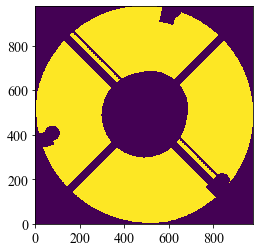

In [3]:
plt.imshow(pmask)

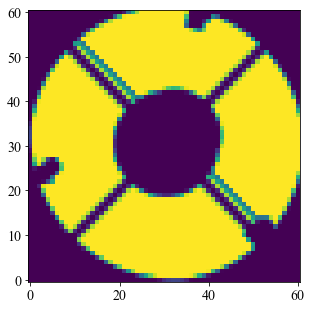

In [4]:
rad = 32
PSZ = rad*4  # size of the array for the model

pdiam   = 2.4*0.955 # telescope diameter in meters
# pmask   = HST(PSZ, PSZ/2, mask="med")
oversample = 5

pmask  = HST(PSZ*(2**oversample), (2**oversample)*PSZ/4, ang=45) # rotated!

def half_bin(array):
    return (array[::2,::2] + array[1::2,::2] + array[::2,1::2] + array[1::2,1::2])/4.

for j in range(oversample):
    pmask = half_bin(pmask)
    
limits = int(PSZ/2-rad*0.955),int(PSZ/2+rad*0.955)
pmask = pmask[limits[0]:limits[1],limits[0]:limits[1]]
pmask = np.array(pmask)

ppscale = pdiam / PSZ


# -------------------------
#      simple plot
# -------------------------
f0 = plt.figure(0)
f0.clf()
ax = f0.add_subplot(111)
ax.imshow(pmask)
f0.set_size_inches(5,5, forward=True)

#f0.savefig("./imgs/HST/rotated_pupil.png")
# -------------------------



In [5]:
hst = morphine.ArrayOpticalElement(opd=np.zeros_like(pmask),
                               transmission=np.array(pmask),
                               pixelscale=ppscale,
                               name='nicmos',planetype=1)
hst.pupil_diam = pdiam

In [6]:
WAVELENGTH = 1.90040e-6
RADIUS = pdiam/2. # meters
PIXSCALE = 0.0431 # arcsec / pix
NWAVES = 1.0
ISZ = 64
FOV = ISZ*PIXSCALE # arcsec
NPIX = PSZ#96


osys = morphine.OpticalSystem(npix=PSZ)
osys.add_pupil(hst)    
osys.pupil_diameter = pdiam
pscale = PIXSCALE
osys.add_detector(pixelscale=PIXSCALE*2, fov_arcsec=FOV)  # image plane coordinates in arcseconds
osys.source_offset_r = 0*pscale
osys.source_offset_theta = 0

In [ ]:
hst.transmission

In [7]:
psf,intermediate = osys.propagate_mono(WAVELENGTH)

TypeError: '<class 'jax.interpreters.xla.DeviceArray'>' object does not support item assignment. JAX arrays are immutable; perhaps you want jax.ops.index_update or jax.ops.index_add instead?

In [15]:
plt.imshow(psf.intensity**0.5)

NameError: name 'psf' is not defined

In [7]:
psf.intensity.shape

(64, 64)

In [8]:
m2pix = xara.core.mas2rad(pscale*1000.) * ISZ / WAVELENGTH
print('m2pix =',m2pix)

m2pix = 3.616325826458078


In [9]:
u = np.linspace(-pdiam,pdiam,NPIX)
uu, vv = np.meshgrid(u,u)

In [10]:
dft1 = np.array(xara.core.compute_DFTM1(onp.array([uu.ravel(),vv.ravel()]).T,m2pix,psf.intensity.shape[0],offset=0.5))

In [11]:
# np.sqrt(dft1.shape[0]).astype('int')

In [12]:
def frantz_ft1(image,FF,norm=1):
    # norm is kpi.TRM.sum() / image.sum()
    myft_v = np.dot(FF,image.flatten())
    myft_v *= norm/image.sum()
    npix = np.sqrt(dft1.shape[0]).astype('int')
    return myft_v.reshape(npix,npix)

In [13]:
cvis1 = frantz_ft1(psf.intensity,dft1)

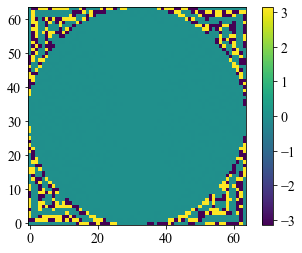

In [14]:
dummy = onp.copy(cvis1)#[32:96,32:96]
# plt.imshow(np.angle(cvis1))

plt.imshow(np.angle(dummy))
plt.colorbar()

## Non Zernike basis?

In [15]:
class mywavefront(morphine.ArrayOpticalElement):
    def __init__(self, wavelength, pupil, phasescreen, **kwargs):
        """ If your optic has adjustible parameters, then save them as attributes here """
        super().__init__()
        self.pupil = pupil
        self.wavelength = wavelength
        self.phasescreen = phasescreen

    def get_opd(self,wave):
        opd = self.phasescreen
        return opd

    def get_transmission(self, wave):
        transmission = self.pupil.get_transmission(wave)
        return transmission

    # behind the scenes morphine  will calculate:
    #    phasor = transmission = np.exp(1.j * 2 * np.pi / wave.wavelength * opd)


In [16]:
wfe = mywavefront(WAVELENGTH,osys.planes[0],np.zeros_like(pmask))

In [17]:
pupil = osys.planes[0]


In [18]:
osys = morphine.OpticalSystem(npix=PSZ)
osys.add_pupil(hst)    # pupil radius in meters
osys.pupil_diameter = pdiam

wf = osys.input_wavefront()
wfe = mywavefront(WAVELENGTH,osys.planes[0],np.zeros_like(wf.coordinates()[0]))
osys.add_pupil(wfe)
osys.add_detector(pixelscale=PIXSCALE*2, fov_arcsec=FOV)

psf,intermediate = osys.propagate_mono(WAVELENGTH)

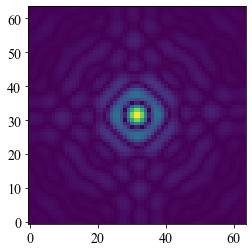

In [19]:
plt.imshow(psf.intensity**0.5)

## Now let's try to autodiff this

In [20]:
def psf_from_phasescreen(phasescreen,wavel=WAVELENGTH):
    osys = morphine.OpticalSystem(npix=PSZ)
    osys.add_pupil(hst)
    osys.pupil_diameter = pdiam

    wf = osys.input_wavefront()
    wfe = mywavefront(wavel,osys.planes[0],phasescreen)
    osys.add_pupil(wfe)
    osys.add_detector(pixelscale=PIXSCALE*2, fov_arcsec=FOV)

    psf,intermediate = osys.propagate_mono(wavel)
    return psf,osys

def end_to_end(phasescreen):
    psf, osys = psf_from_phasescreen(phasescreen)
    return frantz_ft1(psf.intensity,dft1)

def uv_phase(phasescreen):
    return np.angle(end_to_end(phasescreen))

zero_phase = np.zeros_like(wf.coordinates()[0])

output = uv_phase(zero_phase)

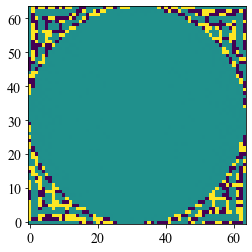

In [21]:
plt.imshow(output)

In [22]:
from jax import jacfwd, jacrev


In [23]:
%load_ext memory_profiler

In [24]:
# phasegrad = jacrev(uv_phase)

In [25]:
# %%memit 

# thisgrad = phasegrad(zero_phase)
# print(thisgrad.sum())


In [26]:
phasegrad = jacfwd(uv_phase)

In [27]:
%%memit 
time = clock()
thisgrad = phasegrad(zero_phase)
print(thisgrad.sum())
print('Time taken:',(clock()-time)/60.,'min')

-4.887580871582031e-05
Time taken: 1.7504759867986044 min
peak memory: 2516.67 MiB, increment: 2059.76 MiB


In [28]:
otf = end_to_end(zero_phase)

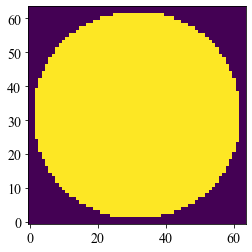

In [29]:
support = np.abs(otf) > 75.0e-4
plt.imshow(support)

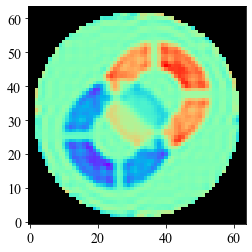

In [30]:
indices = 20

phases = onp.copy(thisgrad[:,:,indices,indices])
phases[support<1.] = np.nan
plt.imshow(phases,cmap=phasemap)


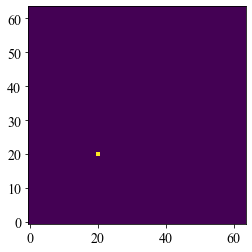

In [31]:
indices = 20
pupil_trans = pmask
phasescreen_test = onp.zeros_like(pupil_trans)
phasescreen_test[indices,indices] = 0.1

plt.imshow(phasescreen_test)

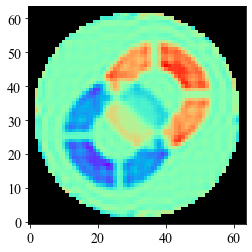

In [32]:
output = onp.array(uv_phase(phasescreen_test))
output[support<1.] = np.nan
plt.imshow(output,cmap=phasemap)


In [33]:
np.floor((pmask.shape[0]/2)).astype('int')

DeviceArray(32, dtype=int64)

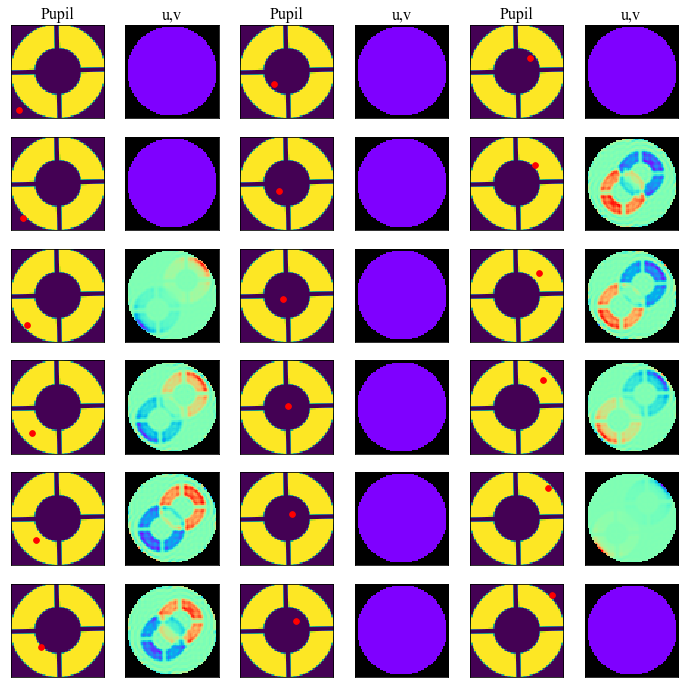

In [34]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 10
fs = 16

# mid = np.floor((pmask.shape[0]/2)).astype('int')
index_step = onp.floor((thisgrad.shape[3])/((3.*rows))).astype('int')

indices = index_step+2

for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
#         ax[i,1+j].imshow(thisgrad[indices,indices,:,:],cmap=phasemap)
        phases = onp.copy(thisgrad[:,:,indices,indices])
        pupil_trans = pmask.copy()
        phases[support<1.] = np.nan
        ax[i,1+j].imshow(phases,cmap=phasemap)

        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('u,v',fontsize=fs)
            ax[i,j].set_title('Pupil',fontsize=fs)

        ax[i,j].imshow(pupil_trans)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

        indices += index_step

# plt.savefig('jacobian.png',bbox_inches='tight')
# plt.savefig('/Users/benjaminpope/code/morphine/paper/hst_jacobian.pdf',bbox_inches='tight')

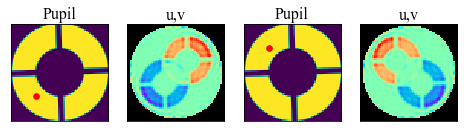

In [80]:
fig, ax = plt.subplots(1,4,figsize=(8,4))
columns = 4
rows = 1
indices = 10
fs = 16

# mid = np.floor((pmask.shape[0]/2)).astype('int')

indices_list = [(16,16),(16,48)]
for j in [0,1]:
    indices = indices_list[j]
    
    phases = onp.copy(thisgrad[:,:,indices[0],indices[1]])
    pupil_trans = pmask.copy()
    phases[support<1.] = np.nan
    ax[1+2*j].imshow(phases,cmap=phasemap)

    ax[1+2*j].set_xticks([])
    ax[1+2*j].set_yticks([])
    ax[1+2*j].set_title('u,v',fontsize=fs)
    ax[2*j].set_title('Pupil',fontsize=fs)

    ax[2*j].imshow(pupil_trans)
    ax[2*j].scatter(indices[0],indices[1],s=32,c='r')
    ax[2*j].set_xticks([])
    ax[2*j].set_yticks([])

    indices += index_step

# plt.savefig('jacobian.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/morphine/paper/hst_jacobian.pdf',bbox_inches='tight')

In [36]:
thisgrad.shape

(64, 64, 64, 64)

In [37]:
mid = np.round((NPIX+1)/2).astype('int')

half = onp.array(support).copy()
half[:,mid:] = 0

pupil_mask = (pupil_trans==1.)

In [38]:
# transfer_martinache = thisgrad[:,:,support>0][pupil_trans==1,:].T

transfer = onp.array(thisgrad.reshape(((NPIX)**2),(PSZ)**2))

transfer = transfer[half.ravel()==1.,:]
transfer = transfer[:,pupil_mask.ravel()]
transfer = transfer[:,1:] # one free phase

In [39]:
print(transfer.shape)

(1458, 1991)


In [40]:
print(pupil_mask.shape)

(64, 64)


In [41]:
print(transfer)

[[-108113.1373696  -105293.88122185 -103842.84315357 ...  105293.88122185
   108113.1373696   118218.53954399]
 [-121361.16347136 -105251.68104128  -95886.70060711 ...  105251.68104128
   121361.16347136  139322.61376746]
 [-143196.42435766 -132388.9810273  -114735.75169074 ...  132388.9810273
   143196.42435766  139254.57191643]
 ...
 [  56503.03902857   62549.23440492   72865.60857724 ...  -62549.23440492
   -56503.03902857  -51579.17234075]
 [  59512.27569577   71245.69013381   82985.46962327 ...  -71245.69013381
   -59512.27569577  -51173.8292749 ]
 [  83543.86539059   89514.32244078   85409.54480428 ...  -89514.32244078
   -83543.86539059  -71976.4735062 ]]


In [42]:
np.sum(pupil_mask)

DeviceArray(1992, dtype=int64)

In [43]:
%%time
u1, s1, v1 = np.linalg.svd((transfer.T),full_matrices=True)

CPU times: user 66.1 ms, sys: 7.48 ms, total: 73.6 ms
Wall time: 59.5 ms


In [44]:
# s1[6000]/s1[0]

In [45]:
 u1.shape, v1.shape

((1991, 1991), (1458, 1458))

In [46]:
np.sum((s1/s1[0])>5e-8)


DeviceArray(282, dtype=int64)

In [47]:
first_k = np.min(np.where(s1/s1[0] == max(set(s1/s1[0]), key=list(s1/s1[0]).count)))

In [48]:
nbuv = np.sum(half>0)
npupil = np.sum(pupil_trans.ravel()>0.)
nkphi = nbuv-first_k
neig = first_k

print('Summary of properties')
print('---------------------------------------------------------------')
print('- %d sub-apertures' % npupil)
print('- %d distinct baselines' % nbuv)
print('- %d Ker-phases (%.1f %% target phase information recovery)' % (nkphi, 100*nkphi/nbuv))
print('- %d Eig-phases (%.1f %% wavefront information recovery)' % (neig,100*neig/npupil))
print('---------------------------------------------------------------')


Summary of properties
---------------------------------------------------------------
- 2456 sub-apertures
- 1458 distinct baselines
- 944 Ker-phases (64.7 % target phase information recovery)
- 514 Eig-phases (20.9 % wavefront information recovery)
---------------------------------------------------------------


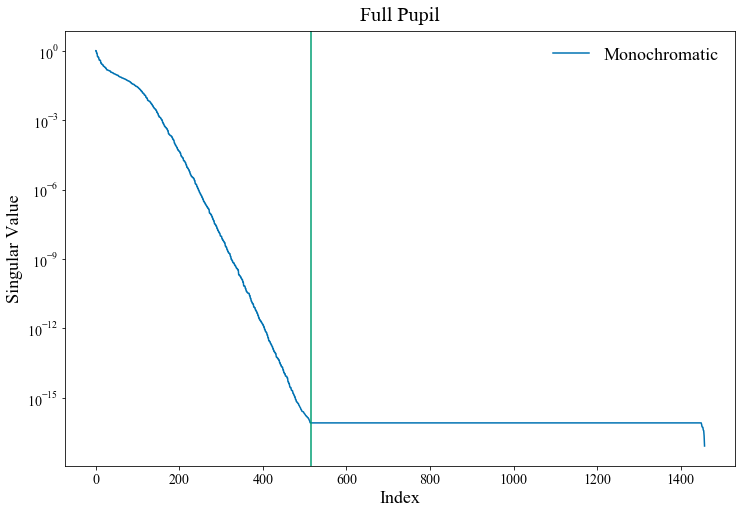

In [49]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(s1/s1[0],label='Monochromatic')
plt.axvline(first_k,color=colours[1])
# plt.plot(broadband['S1'],label='Broadband')
# plt.plot(corona['S1'],label='Lyot Coronagraph')
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')
# plt.title('Kernel Phase Singular Value Spectrum',fontsize=24,y=1.01)
plt.title('Full Pupil',y=1.01,fontsize=20)
plt.legend(fontsize=18,frameon=False)
# plt.savefig('kerphi_singular.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/morphine/paper/hst_kerphi_singular.pdf',bbox_inches='tight')

In [50]:
u1.shape, v1.shape

((1991, 1991), (1458, 1458))

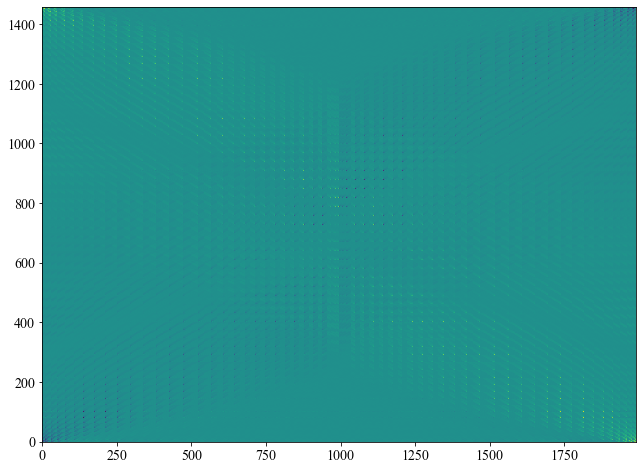

In [51]:
fig = plt.figure(figsize=(12.0,8.0))
plt.imshow((transfer),interpolation=None)

In [52]:
kernel = v1[(first_k+1):,:]
null = np.dot(kernel,transfer)

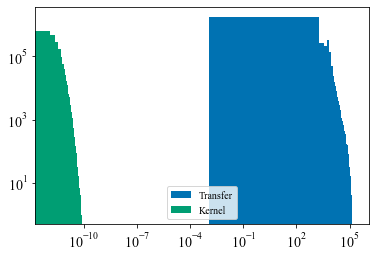

In [53]:
plt.hist(np.abs(transfer.ravel()),bins=100,label='Transfer');
plt.hist(np.abs(null.ravel()),bins=100,label='Kernel');

plt.xscale('log')
plt.yscale('log')
plt.legend()

### Verify this is a transfer matrix

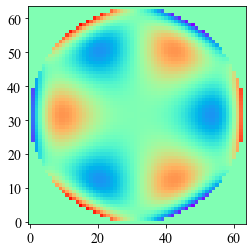

In [54]:
NZ = 20

zernikes = morphine.zernike.zernike_basis(NZ,npix=PSZ,outside=0.0)
plt.imshow(zernikes[-3,:,:],cmap=phasemap)


Text(0.5, 1.0, 'Linear')

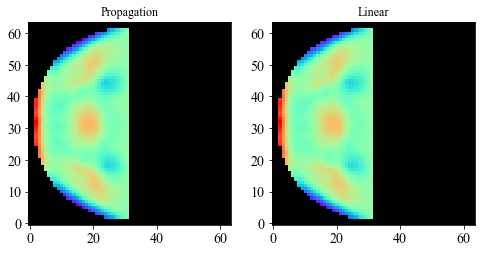

In [55]:
mode = 5e-9*zernikes[-3,:,:]
result = uv_phase(mode)
dummy = onp.array(result)
dummy[half!=1] = np.nan

linear = (onp.dot(transfer,mode[pupil_mask][1:]))
toy = onp.array(onp.nan*result)
toy[half==1.] = linear

fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].imshow(dummy,cmap=phasemap)
axes[0].set_title('Propagation')
axes[1].imshow(toy,cmap=phasemap)
axes[1].set_title('Linear')

### What do these kernel phase maps look like?

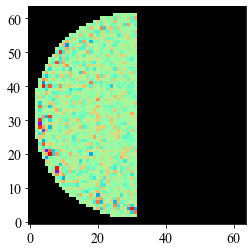

In [56]:
index = first_k+50

mode = 1.*onp.array(half)
mode[half==1.] = v1[index,:]
mode[half!=1.] = np.nan

plt.imshow(mode,cmap=phasemap)

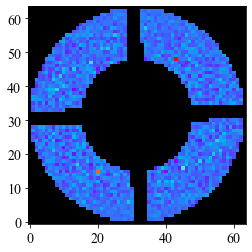

In [57]:
index = 1501

pupil_mode = 1.*onp.array(pupil_trans)
pupil_mode[pupil_mask] = onp.append([0],u1[:,index])
pupil_mode[~pupil_mask] = np.nan

plt.imshow(pupil_mode,cmap=phasemap)

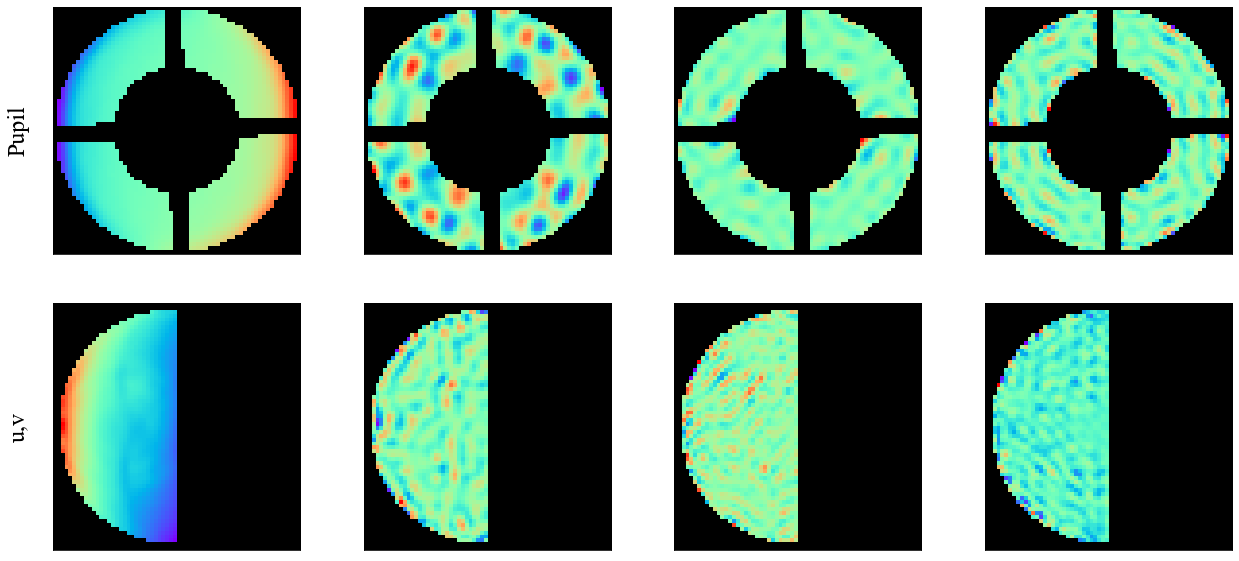

In [58]:
nsets = 4

fig, axes = plt.subplots(2,nsets,figsize=(8/3.*(nsets*2),10))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

axes[0,0].set_ylabel('Pupil',fontsize=24,labelpad=24)

axes[1,0].set_ylabel('u,v',fontsize=24,labelpad=24)

for j in range(nsets):
    mode = 1.*onp.array(half)
    mode[half>0] = v1[j*50,:]
    mode[half<=0] = np.nan

    axes[1,j].imshow(mode,cmap=phasemap)  
    
    wavefront = onp.ones_like(pupil_trans)
    wavefront[pupil_mask] *= onp.append([0],u1[:,j*50]) 
    wavefront[~pupil_mask] = np.nan
    axes[0,j].imshow(wavefront,cmap=phasemap)
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')

plt.savefig('/Users/benjaminpope/code/morphine/paper/hst_nonsingular_modes_mono.pdf',bbox_inches='tight')

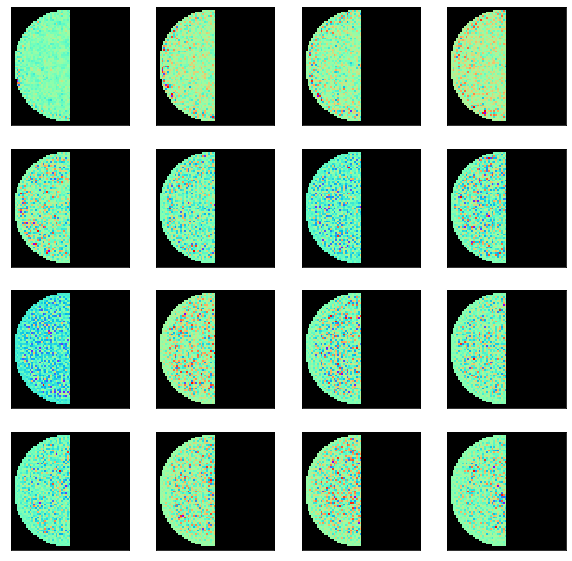

In [59]:
nsets = 4

fig, axes = plt.subplots(nsets,nsets,figsize=(10,10))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

for j, axis in enumerate(axes.ravel()):
    mode = 1.*onp.array(half)
    mode[half==1.] = v1[j*50+first_k,:]
    mode[half<1.] = np.nan

    axis.imshow(mode,cmap=phasemap)  
    
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')

plt.savefig('/Users/benjaminpope/code/morphine/paper/hst_kernel_modes_mono.pdf',bbox_inches='tight')

### Now can we save this as a KPI?

In [60]:
x = np.linspace(-pdiam/2.,pdiam/2.,PSZ)
xx, yy = np.meshgrid(x,x)

mask = onp.array([xx[pupil_mask], yy[pupil_mask],(pupil_trans[pupil_mask])]).T

# u = np.linspace(-pdiam,pdiam,NPIX)
# uu, vv = np.meshgrid(u,u)

uv_samp = onp.array([uu[half==1.], vv[half==1.]]).T



In [61]:
np.sqrt((uv_samp**2).sum(axis=1)).max()/(pdiam)

DeviceArray(0.96942422, dtype=float64)

In [62]:
transfer.shape

(1458, 1991)

In [63]:
kernel

DeviceArray([[ 0.        , -0.0050444 ,  0.01459438, ..., -0.02269582,
              -0.00716469,  0.01066562],
             [ 0.        , -0.00634253,  0.00119875, ..., -0.06265519,
               0.07655151, -0.05704285],
             [ 0.        ,  0.00033266, -0.0118013 , ...,  0.03857939,
               0.05061276, -0.1140392 ],
             ...,
             [ 0.        ,  0.00320866, -0.00402279, ..., -0.06161603,
               0.06908024, -0.04436973],
             [ 0.        , -0.00169835,  0.00337678, ..., -0.00060483,
               0.00869734, -0.00357999],
             [ 0.        , -0.00036316,  0.00311679, ..., -0.00289176,
               0.00448919, -0.0075057 ]], dtype=float64)

In [64]:
 data = {'name'   : 'hstmorphinefrantz_%dbit_%dpix' % (bit,NPIX),
         'mask'   : mask.astype('float64'),
         'uv'     : uv_samp.astype('float64'),
         'TFM'    : transfer.astype('float64'),
         'KerPhi' : kernel.astype('float64'),
         'RED'    : otf[half==1.].astype('float64'),
         'support': half.astype('float64')}

In [65]:
%%time
import gzip, pickle
print('saving to hstmorphinefrantz_%dbit_%dpix.kpi.gz' % (bit,NPIX))
myf = gzip.GzipFile('hstmorphinefrantz_%dbit_%dpix.kpi.gz' % (bit,NPIX), "wb")
pickle.dump(data, myf, -1)
myf.close()
print('saved')

saving to pharomorphinefrantz_64bit_64pix.kpi.gz
saved
CPU times: user 1.6 s, sys: 41.4 ms, total: 1.64 s
Wall time: 1.21 s


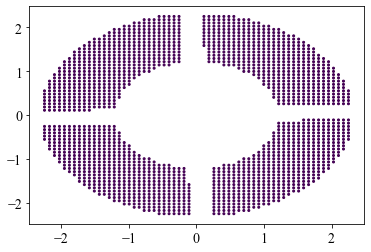

In [66]:
plt.scatter(mask[:,0],mask[:,1],c=mask[:,2],s=4)

In [67]:
import gzip, pickle
myf = gzip.GzipFile('hstmorphinefrantz.kpi.gz','r')
test = pickle.load(myf)
myf.close()

### Now let's see what a binary simulation looks like

In [68]:
NZ = 20

zernikes = morphine.zernike.zernike_basis(NZ,npix=PSZ,outside=0.0)



In [69]:
ISZ

64

In [70]:
coefficients_sequence = 15e-9*onp.random.randn(NZ)


aberrated = morphine.OpticalSystem(npix=PSZ)
aberrated.add_pupil(hst)    # pupil radius in meters
aberrated.pupil_diameter = pdiam

thinlens = morphine.ZernikeWFE(radius=pdiam/2., coefficients=coefficients_sequence, cached_zernikes=zernikes)
aberrated.add_pupil(thinlens)
aberrated.add_detector( pixelscale=PIXSCALE*2, fov_arcsec=ISZ*PIXSCALE )

blur,intermediate = aberrated.propagate_mono(WAVELENGTH,normalize='first')

In [71]:
(thinlens.get_opd(wf)).max()-(thinlens.get_opd(wf)).min()*1e9

DeviceArray(238.1968385, dtype=float64)

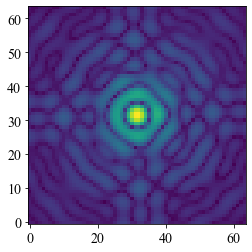

In [72]:
plt.imshow(blur.intensity**0.25)

In [73]:
offset = 0.125

aberrated.source_offset_r = offset
aberrated.source_offset_theta = 86
tilted, intertilt = aberrated.propagate_mono(WAVELENGTH,normalize='first')
aberrated.source_offset_r = 0


In [74]:
contrast = 1./50.
science = contrast*tilted.intensity+blur.intensity

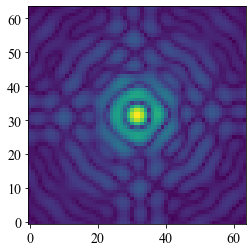

In [75]:
plt.imshow(science**0.25)

In [76]:
import pyfits
hdu = pyfits.PrimaryHDU(science)
hdulist = pyfits.HDUList([hdu])
hdulist.writeto('test_hst.fits',clobber=True)


In [77]:
# # do a bunch of them

# seps = [75,100,125,150]
# cons = [10,25,50]
# thetas = [0,86,180,270]

# for sep in seps:
#     for theta in thetas:
#         aberrated.source_offset_r = sep/1000.
#         aberrated.source_offset_theta = theta
#         tilted, intertilt = aberrated.propagate_mono(WAVELENGTH,normalize='first')
#         for con in cons:
#             science = 1./con*tilted.intensity+blur.intensity
            
#             hdu = pyfits.PrimaryHDU(science)
#             hdulist = pyfits.HDUList([hdu])
#             fname = 'test_hst_s%d_th%d_c%d.fits' % (sep,theta,con)
#             hdulist.writeto(fname,clobber=True)
#             print('Written to %s' % fname)


In [81]:
from tqdm import tqdm
# do a bunch of them
sep, theta, con = 125., 86., 25.
nsim = 1000
science = onp.zeros((nsim,ISZ,ISZ))
amps = []

coefficients_sequence_0 = 15e-9*onp.random.randn(NZ)

for j in tqdm(range(nsim)):

    coefficients_sequence = 20e-9*onp.random.randn(NZ)#+coefficients_sequence_0

    aberrated = morphine.OpticalSystem(npix=PSZ)
    aberrated.add_pupil(hst)    # pupil radius in meters
    aberrated.pupil_diameter = pdiam

    thinlens = morphine.ZernikeWFE(radius=pdiam/2., coefficients=coefficients_sequence, cached_zernikes=zernikes)
    aberrated.add_pupil(thinlens)
    aberrated.add_detector( pixelscale=PIXSCALE*2, fov_arcsec=ISZ*PIXSCALE )
    peak2peak = (thinlens.get_opd(wf)).max()-(thinlens.get_opd(wf)).min()*1e9
    amps.append(peak2peak)

#     blur,intermediate = aberrated.propagate_mono(WAVELENGTH,normalize='first')

#     aberrated.source_offset_r = sep/1000.
#     aberrated.source_offset_theta = theta
#     tilted, intertilt = aberrated.propagate_mono(WAVELENGTH,normalize='first')
#     science[j,:,:] = 1./con*tilted.intensity+blur.intensity

# hdu = pyfits.PrimaryHDU(science)
# hdulist = pyfits.HDUList([hdu])
# fname = 'test_hst_s%d_th%d_c%d_cube.fits' % (sep,theta,con)
# hdulist.writeto(fname,clobber=True)
# print('Written to %s' % fname)

print(np.median(amps),np.std(amps))

100%|██████████| 1000/1000 [00:32<00:00, 30.47it/s]


TypeError: data type not understood

In [84]:
np.median(np.array(amps)), np.std(np.array(amps))

(DeviceArray(295.22303016, dtype=float64),
 DeviceArray(96.56559338, dtype=float64))